### Lecture 3

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
torch.cuda.is_available()

True

In [2]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')


device

device(type='cuda')

In [3]:
noise_dim = 100

#### Generator Model

In [4]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            torch.nn.Linear(
                in_features=noise_dim,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            # Fully Connected Layer 2
            torch.nn.Linear(
                in_features=1200,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=1200,
                out_features=1200,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            # Fully Connected Layer 4
            torch.nn.Linear(
                in_features=1200,
                out_features=784,
                bias=True
            ),
            torch.nn.Sigmoid()
        )

    def forward(self, batch):
        ret = batch.view(batch.size(0), -1)
        ret = self.fcn(ret)
        return ret

#### Maxout Activation

##### Source: https://github.com/pytorch/pytorch/issues/805

In [5]:
class Maxout(torch.nn.Module):

    def __init__(self, num_pieces):

        super(Maxout, self).__init__()

        self.num_pieces = num_pieces

    def forward(self, x):

        # x.shape = (batch_size? x 625)

        assert x.shape[1] % self.num_pieces == 0  # 625 % 5 = 0

        ret = x.view(
            *x.shape[:1],  # batch_size
            x.shape[1] // self.num_pieces,  # piece-wise linear
            self.num_pieces,  # num_pieces
            *x.shape[2:]  # remaining dimensions if any
        )
        
        # ret.shape = (batch_size? x 125 x 5)

        # https://pytorch.org/docs/stable/torch.html#torch.max        
        ret, _ = ret.max(dim=2)

        # ret.shape = (batch_size? x 125)

        return ret

#### Discriminator Model

In [6]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            torch.nn.Linear(
                in_features=784,
                out_features=625,
                bias=True
            ),
            Maxout(5),
            # Fully Connected Layer 2
            torch.nn.Linear(
                in_features=125,
                out_features=625,
                bias=True
            ),
            Maxout(5),
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=125,
                out_features=1,
                bias=True
            ),
            torch.nn.Sigmoid()
        )

    def forward(self, batch):
        ret = batch.view(batch.size(0), -1)
        ret = self.fcn(ret)
        return ret

### Lecture 4

#### MNIST Dataset

In [7]:
import torchvision

In [8]:
class FlattenTransform:
    
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)
        

data_train = torchvision.datasets.MNIST(
    './data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        FlattenTransform()
    ])
)

In [9]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

#### GAN Training

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


discriminator_optimizer = torch.optim.SGD(
    discriminator.parameters(),
    lr=0.0002,
    momentum=0.5
)

generator_optimizer = torch.optim.SGD(
    generator.parameters(),
    lr=0.0002,
    momentum=0.5
)

criterion = torch.nn.BCELoss()

In [11]:
real_labels = torch.ones(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

test_set = torch.randn(16, noise_dim).to(device)

num_epochs = 512
num_steps = len(train_loader) // BATCH_SIZE

In [16]:
import os

if not os.path.exists('visuals'):
    os.mkdir('visuals')

In [17]:
for epoch in range(num_epochs):

    for i, (images, _) in enumerate(train_loader):

        if i == num_steps:
            break

        # Train Discriminator
        for _ in range(8):
        
            real_images = images.to(device)

            fake_images = generator(
                torch.randn(BATCH_SIZE, noise_dim).to(device)
            )

            discriminator_optimizer.zero_grad()

            real_outputs = discriminator(real_images)
            fake_outputs = discriminator(fake_images)

            d_x = criterion(real_outputs, real_labels)
            d_g_z = criterion(fake_outputs, fake_labels)

            d_x.backward()
            d_g_z.backward()

            discriminator_optimizer.step()

        # Train Generator
        z = torch.randn(BATCH_SIZE, noise_dim).to(device)

        generator.zero_grad()

        outputs = discriminator(generator(z))

        loss = criterion(outputs, real_labels)

        loss.backward()

        generator_optimizer.step()

    # Visualize Results
    if epoch % 10 == 0:
        print(f"[INFO] epoch : {epoch} | loss generator: {loss.item()}")
        generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

        grid = torchvision.utils.save_image(
            generated,
            os.path.join(
                'visuals',
                '{}.jpg'.format(
                    str(epoch).zfill(6)
                )
            ),
            nrow=4,
            padding=10,
            pad_value=1
        )

[INFO] epoch : 0 | loss generator: 1.4585587978363037
[INFO] epoch : 0 | loss generator: 1.4695985317230225
[INFO] epoch : 0 | loss generator: 1.4795818328857422
[INFO] epoch : 0 | loss generator: 1.488485336303711
[INFO] epoch : 0 | loss generator: 1.4974722862243652
[INFO] epoch : 0 | loss generator: 1.5094952583312988
[INFO] epoch : 0 | loss generator: 1.519084095954895
[INFO] epoch : 0 | loss generator: 1.5276412963867188
[INFO] epoch : 0 | loss generator: 1.5368101596832275
[INFO] epoch : 0 | loss generator: 1.545236349105835
[INFO] epoch : 0 | loss generator: 1.5561408996582031
[INFO] epoch : 0 | loss generator: 1.5672484636306763
[INFO] epoch : 0 | loss generator: 1.5765568017959595
[INFO] epoch : 0 | loss generator: 1.5853486061096191
[INFO] epoch : 0 | loss generator: 1.5970842838287354
[INFO] epoch : 0 | loss generator: 1.6049795150756836
[INFO] epoch : 0 | loss generator: 1.613915205001831
[INFO] epoch : 0 | loss generator: 1.621455192565918
[INFO] epoch : 0 | loss generator

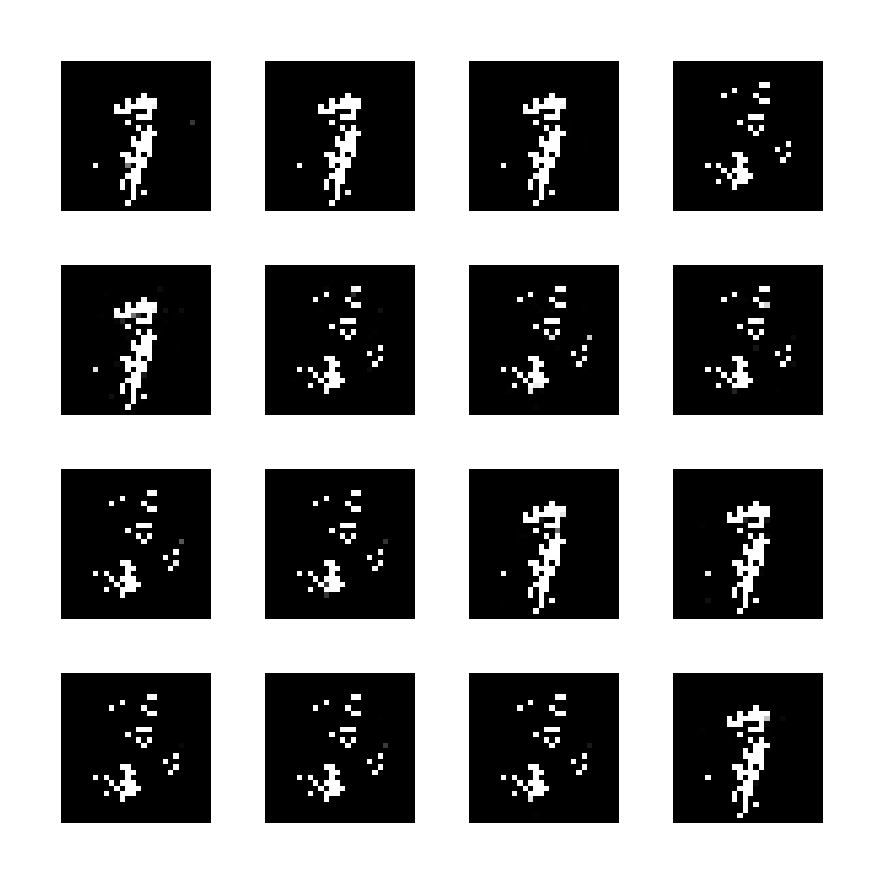

In [18]:
# Visualize Results
generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

grid = torchvision.utils.make_grid(
    generated,
    nrow=4,
    padding=10,
    pad_value=1
)

img = np.transpose(
    grid.numpy(),
    (1, 2, 0)
)

fig = plt.figure(figsize=(16, 16))
plt.axis("off")
plt.imshow(img);

#### Google Collaboratory

Notebook: https://colab.research.google.com/drive/14zSDErgZ8cNn9UEHgh2x2tPhao9HVYn5